Nome: Guilherme Cramer Barbosa Silva

Matricula: 2015102170

link explicação: https://drive.google.com/file/d/19w7t6UQXYAZgUN6I-4cGKqQf24YD-3Bi/view?usp=sharing

In [ ]:
from frequency_domain_reconstruction import freq_Domain
import matplotlib
import matplotlib.pyplot as plt
from scipy import fftpack
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture as GMM
from sklearn.mixture import BayesianGaussianMixture as BGMM
from keras.models import load_model
import keras
import sys
import os
from sklearn.metrics import confusion_matrix

### Introdução e Objetivos.

O trabalho em questão aborda a geração aleatório de dados no contexto de reconhecimento de atividades humanas (classificação) através de dados de sensores. 

Diante desse cenário o objetivo do trabalho final da disciplina de "DCC-831 Machine Learning" é de gerar amostras aleatoriamente de uma determinada classe (atividade) a partir a distribuição de probabilidade aprendida a partir dos dados. Existem dois grandes objetivos na tarefa proposta: inicialmente é realizar um oversampling de determinada atividade (classe) a fim de lidar melhor com datasets que possuem uma base de dados desbalanceada. O segundo objetivo é realizar o chamado "data argumentation", que consiste em passar ao modelo amostras de dados que são resultados de transformações a fim de melhorar o desenpenho do modelo em um cenário real. Essa qustão deo "data argumentation" será melhor discutida ao longo do código. 

Vale ressaltar que o medelo de classificação não será abordado nesse trabalho, visto que não é o objetivo do mesmo e também não foi desnvolvido por mim e sim por uma colega de pesquisa. 



### Dataset information:

O dataset chamado "MHEALTH" foi retirado do site UCI (http://archive.ics.uci.edu/ml/datasets/mhealth+dataset). A seguir é mostrado uma breve descrição retirada do site. 

The MHEALTH (Mobile HEALTH) dataset comprises body motion and vital signs recordings for ten volunteers of diverse profile while performing several physical activities. Sensors placed on the subject's chest, right wrist and left ankle are used to measure the motion experienced by diverse body parts, namely, acceleration, rate of turn and magnetic field orientation. The sensor positioned on the chest also provides 2-lead ECG measurements, which can be potentially used for basic heart monitoring, checking for various arrhythmias or looking at the effects of exercise on the ECG.

Para o trabalho em questão, apenas as features que compreendem ao acelerômetro  do pulso direito (right wrist) foram ultilizados. Isso se deu para simplificar o problema e já é sabido a princípio que essas são as features mais discriminativas para o problema em questão.
Os dados estão no seguinte formato: (samples,chanel,timesteps,eixos).

No nosso caso, o dataset possúi o as seguintes dimensões: (2550,1,250,3)

### Desenvolvimento

##### Getting the data
Primeiramente o data set foi lido. A função não foi mostrada explicitamente pois foi usado uma classe que uso em outros experimentos. 
Em seguida, são filtrados os indices de uma determinada atividade. Exitem 12 possíveis. 

In [20]:
fd = freq_Domain()
#fd.set_data(dataset_name='UTD-MHAD2_1s')
fd.set_data(dataset_name='MHEALTH')
%matplotlib inline
#fd.plot_reconstruction(0)
classes = pd.unique(fd.data_y)
classes_idx = []
for c in classes:
    classes_idx.append(np.where(fd.data_y==c)[0][:])

sensor factor: 
1.0.0
MHEALTH.npz
sensor factor: 
1.0.0
MHEALTH.npz


In [21]:
dataX = np.expand_dims(fd.data_x,axis = 1)
dataY =  fd.data_y


2555

##### Chosing a class:
Obs.: o nome das atividades estão em ordem diferente das mostradas no site. 

In [22]:
classe = 9
atividade = ' Standing still'
train_X = fd.data_x[classes_idx[classe]].copy()
y_true = fd.data_y[classes_idx[classe]]

#### Transform into frequency domain:
Nessa parte é realizado um pré-processamento. Os dados são trasformados para o domínio da frequência. Essa transformação é muito útil para a redução de dimensionalidade, visto que é possível usar apenas as primeiras 'X' frequências; além disso os dados resultantes são muito mais "bem comportados", visto que os valores ficam menores em magnetude (próximos de zero)

In [23]:
x_freq = []
y_freq = []
z_freq = []

for x in train_X:
    x_freq.append(fftpack.rfft(x[:,0]))
    y_freq.append(fftpack.rfft(x[:,1]))
    z_freq.append(fftpack.rfft(x[:,2]))

### Criando o modelo
O Modelo escolhido para a modelagem da distribuição de probabilidade foi o de misturas de gaussianas. Esse foi um modelo visto em sala de aula, com o intuito de abordar o problema de aprendizado não supervisionado. Enttretanto, no trabalho em quastão ele foi usado com a finalidade de aprender a distribuição dos dados 

O modelo escolhido foi o de mistura de gaussianas (sklearn.mixture.GaussianMixture) com apenas uma componente (n_components=1) visto que já sabemos que existe apenas uma classe nos dados em questão. 
O modelo foi construido de forma que cada componente tem sua própria matriz de covariância geral. Esse hiperparâmetro (covariance_type) foi testado todas as possibilidades, mas não houve grandes mudanças. 
Vale ressaltar que foi criado um modelo para cada um dois eixos do sensor. 

In [24]:
bgmmX = GMM(n_components=1,covariance_type='full')
bgmmX.fit(x_freq)
bgmmY = GMM(n_components=1,covariance_type='full')
bgmmY.fit(y_freq)
bgmmZ = GMM(n_components=1,covariance_type='full')
bgmmZ.fit(z_freq)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=1, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

#### Gerando amostras:

In [25]:
nSamples = 50
x = np.expand_dims(bgmmX.sample(nSamples)[0],axis = 2)
y = np.expand_dims(bgmmY.sample(nSamples)[0],axis = 2)
z = np.expand_dims(bgmmZ.sample(nSamples)[0],axis = 2)
samples = np.concatenate((x,y,z),axis = -1)

#### Transforming back into time domain

In [26]:
genSamples = []
for s in samples:
    gX = np.expand_dims(fftpack.irfft(s[:,0]),axis = 1)
    gY =np.expand_dims(fftpack.irfft(s[:,1]),axis = 1)
    gZ =np.expand_dims(fftpack.irfft(s[:,2]),axis = 1)
    genS = np.concatenate((gX,gY,gZ),axis = -1)
    genSamples.append(genS)
genSamples= np.array(genSamples)   
genSamples = np.expand_dims(genSamples,axis = 1)

#### Mostrando os resultados
A seguir será mostrado um exemplo de resultado obtido a partir das amostras geradas. 
Como o objetivo não é replicar as amostras em si, não foi aplicadas métricas de erro, como mean_score_error ou outras parecidas.
Isso se dá pelo fato de que o intuito é que as amostras sejam de fato diferente, mas mantendo as características discriminativas da classe em questão. 

(-20, 20)

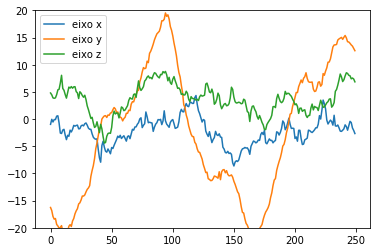

In [65]:
y_lim = 20
plt.plot(genSamples[10][0])
plt.legend(['eixo x', 'eixo y','eixo z'])
plt.ylim([-y_lim,y_lim])

(-20, 20)

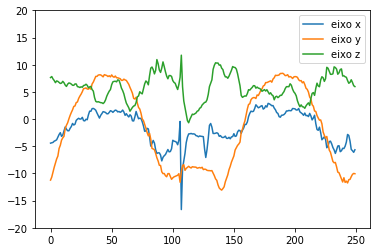

In [64]:
plt.plot(train_X[10])
plt.legend(['eixo x', 'eixo y','eixo z'])
plt.ylim([-y_lim,y_lim])

#### Validando resultados
Para de fato validar os resultados, e demostrar de maneira objetiva que as amostras geradas são de fato discriminativas com a classe escolhida, é necessário classificar essas amostras e para concluir que o experimento de fato foi um sucesso.
O classificador em qustão, é uma rede convolucional em conjunto com um MLP (rede Densa). Os deltalhes de implementação desse classificador não serão abordados aqui. 


In [57]:
modelName = 'ModelMHEALTH.h5'
clf = load_model(modelName)
result = clf.predict(genSamples)
resClasse = [np.argmax(i) for i in result]
acc = len(resClasse[resClasse==classe]/len(resClasse))
print('Acuracia: ', acc, '%')

(50, 1, 250, 3)

#### Conclusão:

Diante dos resultados apresentados é possível concluir que o objetivo foi atingido e os resultados foram satisfatórios, visto que as amostras geradas são, de certa forma, parecidas com os dados originais. 

#### Proximos passos
O experimento abordado se mostrou bastante promissor e como próximos passos, podemos abordar : 
* Variar o número de frequencias usadas na modelagem da distribuição a fim de gerar amostras diferentes de uma certa classe.
* treinar o classificador com várias amostras sintéticas de todas as classes e velidar se de fato a acurácia no dado de teste aumenta, para assim validar o "data argumentation"